In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
# Add a constant to the model (intercept)
from sklearn.metrics import r2_score
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
supporting_features_1 = [
    'CBOE DJIA Volatility Index',
    'NASDAQ 100 Index return',
    'Manufacturers inventories to sales ratio',
    '30 year conventional mortgage rate',
    'Communication Services', 
    'Consumer Discretionary', 
    'Senior secured',  
    'Time to maturity',  
    'Equity value',
    'CDS availability',
    'ActIndustryDistress1',
    'ActIndustryDistress2',
    'Offering amount',
    'Volume',
    'Industrials','Consumer Staples','Financials','Energy','Health Care','Utilities','Information Technology','Real Estate'
]

supporting_features_2 = [
    'Default barrier',
    'LTDIssuance2',
    'Intangibility',
    'Receivables1',
]

presentation_labels = ['negative_sentiment', 'positive_sentiment', 'uncertainty', 'optimistic', 'pessimistic', 'vagueness', 'language_accessibility_presentation',
              'liquidity_position', 'debt_leverage_stress', 'operational_trends', 'industry_positioning', 'asset_quality', 'recovery_strategies', 'legal_issues','macroeconomic']

qna_labels = ['analyst_concerns', 'responsiveness', 'confidence', 'evasiveness', 'depth', 'analyst_satisfaction', 'language_accessibility_qna']

qna_mgmt = ['responsiveness', 'confidence', 'depth', 'evasiveness', 'language_accessibility_qna']
qna_analysts = ['analyst_concerns', 'analyst_satisfaction']

emotions = [
        'admiration', 
        #'amusement', 
        'anger', 
        'annoyance', 
        'approval', 
        'caring', 
        'confusion', 
        'curiosity', 
        'desire',
        'disappointment', 
        'disapproval', 
        #'disgust', 
        'embarrassment', 
        'excitement', 
        'fear', 
        #'gratitude', 
        #'grief',
        'joy', 
        #'love', 
        'nervousness', 
        'optimism', 
        'pride', 
        'realization', 
        'relief', 
        'remorse', 
        'sadness', 
        'surprise'
    ]

analyst_emotions = []
for i in emotions:
    analyst_emotions.append(i + '_analysts')

primary_dealer_features = [
    'HHI_number', 'TimeToMaturity', 'TimeSinceOffering', 'Offering_amount',
       'Rating', 'JunkDummy', 'UnratedDummy', 'Enhanced', 'Redeemable',
       'SinkingFund', 'BOND_COUPON', 'IQ_CDS_availability', 'COVENANTS',
        'AvgTransVol', 'TRADES_VOL', 'amihud_ILLIQ_trades',
       'price_dispersion_volumeweighted', 'EquityValue', 'DefaultBarrier2',
       'NumberEmployees', 'IndDis1', 'IndDis2', 'Slope', 'X90DayDR', 'GDP',
       'TradeSize_Retail', 'TradeSize_SmallInstitutional',
       'Seniority_SeniorSubordinate', 'Seniority_SeniorUnsecured',
       'Seniority_SubordinateJunior', 'Default_DefRating',
       'Default_Distressed_exchange', 'Default_Liquidation_C7',
       'Default_RiskRating'
]

In [3]:
def create_colored_chart(model):

    # Filter significant features
    significant_features = model.pvalues[model.pvalues < 0.05].index
    importances = model.params[significant_features]  # Only significant features
    importances = importances[1:]

    # Sort importances by their absolute value, and select the top 10
    top_12_importances = importances.abs().sort_values(ascending=False).head(10)
    importances = importances[top_12_importances.index]
    importances = importances.sort_values()  # Sort the values for better visualization

    # Apply the color mapping to the top 12 significant features
    colors = []
    for feature in importances.index:
        if feature in supporting_features_1 or feature in supporting_features_2 or feature in primary_dealer_features:
            colors.append('blue')
        else:
            colors.append('purple')  # Default for unknown features

    # Create a horizontal bar plot for the top 12 significant features
    plt.figure(figsize=(10, 5))
    plt.barh(importances.index, importances.values, color=colors)

    # add std errors
    plt.errorbar(importances, importances.index, xerr=model.bse[1:][importances.index], fmt='|', color='black')

    # Add labels and title
    plt.xlabel('Impact')
    plt.ylabel('Features')
    plt.title('Significant Features and their Impact')

    # Create a custom legend
    handles = [
        plt.Rectangle((0, 0), 1, 1, color='blue'),
        plt.Rectangle((0, 0), 1, 1, color='purple'),
    ]
    labels = [
            'Financial Data', 
            'New Metrics',
            ]
    # Add the legend
    plt.legend(handles, labels)

    # Show the plot
    return plt.show()


def create_significant_chart(model):

    # select significant features
    model.significance = model.pvalues[model.pvalues < 0.05].index

    # build a graph to show the importance of each feature
    importances = model.params[1:]
    importances = importances.sort_values()

    # Sort the importance values based on absolute values, not just positive or negative
    top_10_importances = importances.abs().sort_values(ascending=False).head(10)

    # reduce importances to only the top 10
    importances = importances[top_10_importances.index]
    importances = importances.sort_values()

    # color significant features 0/150/130 and others in grey
    colors = ['#009682' if feature in model.significance else 'grey' for feature in importances.index]

    plt.figure(figsize=(10, 5))
    plt.barh(importances.index, importances.values, color=colors)

    # add std errors
    plt.errorbar(importances, importances.index, xerr=model.bse[1:][importances.index], fmt='|', color='black')
    
    # add legend
    plt.legend(['Significant'])
    plt.xlabel('Impact')
    plt.ylabel('Features')
    plt.title('Features Impact on Recovery Rate')
    return plt.show()

In [7]:
def build_score_overview(df):    

    graph_df = df[['Date', 'MTS', 'CAMI', 'AUS', 'call_ID']]
    graph_df = graph_df.drop_duplicates(subset=['Date', 'call_ID'])

    # Set Seaborn style for a cleaner look
    sns.set(style="whitegrid")

    # Convert Date to pandas datetime format if not already done
    graph_df['Date'] = pd.to_datetime(graph_df['Date'])

    # Calculate rolling averages for smoother trends
    graph_df['MTS_Rolling'] = graph_df['MTS'].rolling(window=30).mean()
    graph_df['CAMI_Rolling'] = graph_df['CAMI'].rolling(window=30).mean()
    graph_df['AUS_Rolling'] = graph_df['AUS'].rolling(window=30).mean()

    # Plotting with customized aesthetics
    plt.figure(figsize=(14, 8))
    plt.plot(graph_df['Date'], graph_df['MTS_Rolling'], label='MTS (30-day avg)', linestyle='-', color='steelblue', linewidth=2)
    plt.plot(graph_df['Date'], graph_df['CAMI_Rolling'], label='CAMI (30-day avg)', linestyle='--', color='darkorange', linewidth=2)
    plt.plot(graph_df['Date'], graph_df['AUS_Rolling'], label='AUS (30-day avg)', linestyle=':', color='seagreen', linewidth=2)

    # Original data as lighter points
    plt.scatter(graph_df['Date'], graph_df['MTS'], color='steelblue', alpha=0.4, s=10)
    plt.scatter(graph_df['Date'], graph_df['CAMI'], color='darkorange', alpha=0.4, s=10)
    plt.scatter(graph_df['Date'], graph_df['AUS'], color='seagreen', alpha=0.4, s=10)

    # Formatting the x-axis for date readability
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Set major ticks every 3 months
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    # Adding labels, title, and legend
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Composite Score', fontsize=12)
    plt.title('Trends of MTS, CAMI, and AUS Over Time (with 7-day Rolling Average)', fontsize=14)
    plt.legend()

    plt.tight_layout()
    plt.xticks(rotation=45)
    return plt.show()

def build_heatmap_macro(df):
    # Reducing the correlation matrix to show only MTS, CAMI, AUS with economic factors
    economic_factors = ['CBOE DJIA Volatility Index', 'NASDAQ 100 Index return', 
                        'Manufacturers inventories to sales ratio', '30 year conventional mortgage rate']

    correlation_columns = ['MTS', 'CAMI', 'AUS', 'CBOE DJIA Volatility Index', 'NASDAQ 100 Index return', 
                        'Manufacturers inventories to sales ratio', '30 year conventional mortgage rate']

    graph_df = df[['Date', 'MTS', 'CAMI', 'AUS', 'call_ID'] + economic_factors]
    graph_df = graph_df.drop_duplicates()

    # Calculating correlations
    correlation_matrix = graph_df[correlation_columns].corr()

    # Selecting only the relevant correlations
    reduced_correlation_matrix = correlation_matrix.loc[['MTS', 'CAMI', 'AUS'], economic_factors]

    # Plotting the reduced correlation heatmap
    plt.figure(figsize=(8, 5))
    sns.heatmap(reduced_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title("Correlation of MTS, CAMI, AUS with Economic Indicators")
    return plt.show()

def build_heatmap_industries(df): 
    # display avg scores of MTS, CAMI, AUS for 'Industrials','Consumer Staples','Financials','Energy','Health Care','Utilities','Information Technology','Real Estate'
    graph_df = df[['Date', 'MTS', 'CAMI', 'AUS', 'call_ID', 'Industrials','Consumer Staples','Financials','Energy','Health Care','Utilities','Information Technology','Real Estate']]
    graph_df = graph_df.drop_duplicates(subset=['Date', 'call_ID'])

    industry_scores = {
        'Industrials': graph_df[graph_df['Industrials'] == 1][['MTS', 'CAMI', 'AUS']].mean(),
        'Consumer Staples': graph_df[graph_df['Consumer Staples'] == 1][['MTS', 'CAMI', 'AUS']].mean(),
        'Financials': graph_df[graph_df['Financials'] == 1][['MTS', 'CAMI', 'AUS']].mean(),
        'Energy': graph_df[graph_df['Energy'] == 1][['MTS', 'CAMI', 'AUS']].mean(),
        'Health Care': graph_df[graph_df['Health Care'] == 1][['MTS', 'CAMI', 'AUS']].mean(),
        'Utilities': graph_df[graph_df['Utilities'] == 1][['MTS', 'CAMI', 'AUS']].mean(),
        'Information Technology': graph_df[graph_df['Information Technology'] == 1][['MTS', 'CAMI', 'AUS']].mean(),
        'Real Estate': graph_df[graph_df['Real Estate'] == 1][['MTS', 'CAMI', 'AUS']].mean()
    }

    industry_scores_df = pd.DataFrame(industry_scores)

    # Plotting the average scores for each industry
    plt.figure(figsize=(10, 6))
    sns.heatmap(industry_scores_df, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title("Average MTS, CAMI, AUS Scores by Industry")
    return plt.show()

In [171]:
def compute_scores(df, model, significant=False, emotion=True):

    # Function to normalize a subset of parameters
    def normalize_params(params, features):
        subset_params = np.abs(params[features])
        return subset_params / np.sum(subset_params)

    def finalize_weights(weights, features, params):
        # if features has negative values, set the weights to negative
        for feature in features:
            if params[feature] < 0:
                weights[feature] = -weights[feature]
                print(f"Setting {feature} to negative")
        return weights

    # Features used in each score
    mts_features = [
        'language_accessibility_presentation',
        'language_accessibility_qna',
        'responsiveness',
        #'depth',
        'evasiveness',
        'optimistic', #+
        'pessimistic', #-
        'uncertainty',
        'vagueness',
        'positive_sentiment',
        ]

    cami_features = [
        'debt_leverage_stress',
        'confidence',
        'recovery_strategies',
        'legal_issues',
        'macroeconomic',
        'industry_positioning',
        'operational_trends',
        'liquidity_position',
        'asset_quality',
        ]

    aus_features = [
        'analyst_concerns',
        'analyst_satisfaction',
        ]
    
    if emotion:
        cami_features += ['excitement', 'optimism', 'relief', 'anger', 'fear', 'embarrassment',
                         'disappointment', 'disapproval', 'sadness', 'remorse',
                         'admiration', 'pride', 'joy', 'approval', 'confusion', 'desire']
        aus_features += ['fear_analysts', 'optimism_analysts', 'disapproval_analysts', 'sadness_analysts',
                         'anger_analysts', 'embarrassment_analysts', 'remorse_analysts', 'joy_analysts']

    if significant:
        significant_features = model.pvalues[model.pvalues < 0.05].index
        # reduce to only significant features
        mts_features = list(set(mts_features).intersection(significant_features))
        print(mts_features)
        cami_features = list(set(cami_features).intersection(significant_features))
        aus_features = list(set(aus_features).intersection(significant_features))

    # Get the absolute values of the coefficients and subtract standard error
    abs_params = np.abs(model.params)

    # Normalize parameters for each score
    mts_weights = normalize_params(abs_params, mts_features)
    cami_weights = normalize_params(abs_params, cami_features)
    aus_weights = normalize_params(abs_params, aus_features)

    # Finalize the weights
    mts_weights = finalize_weights(mts_weights, mts_features, model.params)
    cami_weights = finalize_weights(cami_weights, cami_features, model.params)
    aus_weights = finalize_weights(aus_weights, aus_features, model.params)

    # Management Transparency Score (MTS)
    df['MTS'] = np.dot(df[mts_features], mts_weights)

    # Crisis Awareness and Management Index (CAMI)
    df['CAMI'] = np.dot(df[cami_features], cami_weights)

    # Analysts Urgency Score (AUS)
    df['AUS'] = np.dot(df[aus_features], aus_weights)

    return df


In [256]:
def create_loadings(df):
    # Helper function to compute the first principal component for a subset of columns
    def pca_weights(df, features, n_components=1):
        # Run PCA on the selected features
        pca = PCA(n_components=n_components)
        pca.fit(df[features])

        # Use the loadings of the first principal component as weights
        weights = pca.components_[0]

        # Normalize weights to sum to 1
        #weights = weights / np.sum(np.abs(weights))

        return np.abs(weights)

    no_transparency = [
        'evasiveness', #-
        'vagueness', #-
        'positive_sentiment'
        ]
    
    no_awareness = [
        'macroeconomic', #-
        'industry_positioning', #+
        'operational_trends', #-
        'asset_quality',  #-
        ]
    
    openess = [
        'language_accessibility_presentation', #-
        'debt_leverage_stress', #-
        'recovery_strategies', #+
        'legal_issues', #-
        'optimistic', #+
        ]
    
    Emotional_concerns = [
        'analyst_concerns', #+
        'anger_analysts', 
        'embarrassment_analysts', 
        'remorse_analysts'
        ]
    
    True_negativity = [
        #'analyst_satisfaction', #+
        #'optimism_analysts', 
        #'joy_analysts', 
        'disapproval_analysts', 
        'fear_analysts',
        'sadness_analysts'
        ]
    
    True_satisfaction = [
        'analyst_satisfaction', #+
        'optimism_analysts', 
        'joy_analysts', 
        ]
    
    no_transparency_weights = pca_weights(df, no_transparency)
    no_awareness_weights = pca_weights(df, no_awareness)
    openess_weights = pca_weights(df, openess)
    emotional_weights = pca_weights(df, Emotional_concerns)
    negative_weights = pca_weights(df, True_negativity)
    professional_weights = pca_weights(df, True_satisfaction)

    df['No_Transparency'] = np.dot(df[no_transparency], no_transparency_weights)
    df['No_Awareness'] = np.dot(df[no_awareness], no_awareness_weights)
    df['Openess'] = np.dot(df[openess], openess_weights)
    df['Emotional_Concerns'] = np.dot(df[Emotional_concerns], emotional_weights)
    df['True_Satisfaction'] = np.dot(df[True_satisfaction], professional_weights)
    df['True_Negativity'] = np.dot(df[True_negativity], negative_weights)
    
    # Define emotion groups for MANAGEMENT
    constructive_engagement = ['excitement', 'relief', 'anger', 'fear', 'embarrassment', 'admiration', 'realization']
    ambiguous_emotions = ['disappointment', 'sadness', 'remorse', 'confusion', 'surprise', 'pride', 'joy', 'approval', 'desire']

    constructive_weights = pca_weights(df, constructive_engagement)
    ambiguous_weights = pca_weights(df, ambiguous_emotions)

    df['Constructive_Engagement_Score'] = np.dot(df[constructive_engagement], constructive_weights)
    df['Ambiguous_Emotion_Score'] = np.dot(df[ambiguous_emotions], ambiguous_weights)

    df['Emotion_Valuation'] = df['Constructive_Engagement_Score'] - df['Ambiguous_Emotion_Score']
    #df.drop(columns=['Constructive_Engagement_Score', 'Ambiguous_Emotion_Score'], inplace=True)

    def normalize_scores(df, columns):
        for col in columns:
            min_val = df[col].min()
            max_val = df[col].max()
            df[col + '_Normalized'] = (df[col] - min_val) / (max_val - min_val)
        return df

    return df

In [150]:
baseline_model = sm.load('models/aggregated_all_features_model.pkl')
llm_outputs = pd.read_csv('transcripts/LLM_outputs_final.csv')

Setting evasiveness to negative
Setting pessimistic to negative
Setting uncertainty to negative
Setting vagueness to negative
Setting positive_sentiment to negative
Setting confidence to negative
Setting macroeconomic to negative
Setting industry_positioning to negative
Setting operational_trends to negative
Setting asset_quality to negative
                            OLS Regression Results                            
Dep. Variable:                     RR   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.708
Method:                 Least Squares   F-statistic:                     90.63
Date:                Thu, 21 Nov 2024   Prob (F-statistic):          1.62e-261
Time:                        14:46:56   Log-Likelihood:                -4346.1
No. Observations:                1075   AIC:                             8752.
Df Residuals:                    1045   BIC:                             8902.
Df Model:               

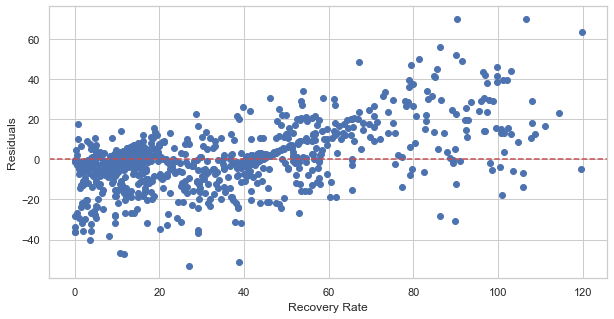

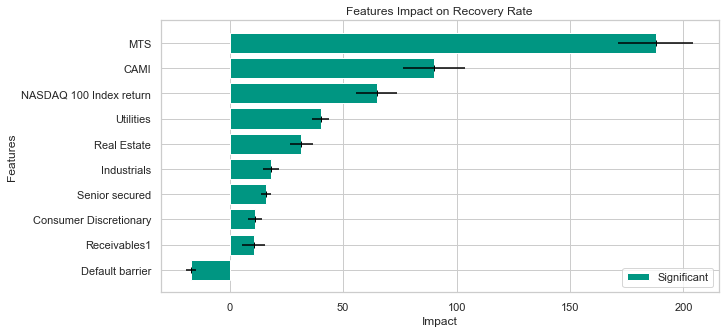

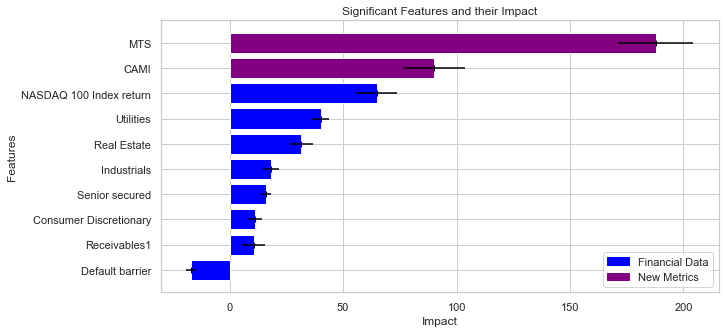

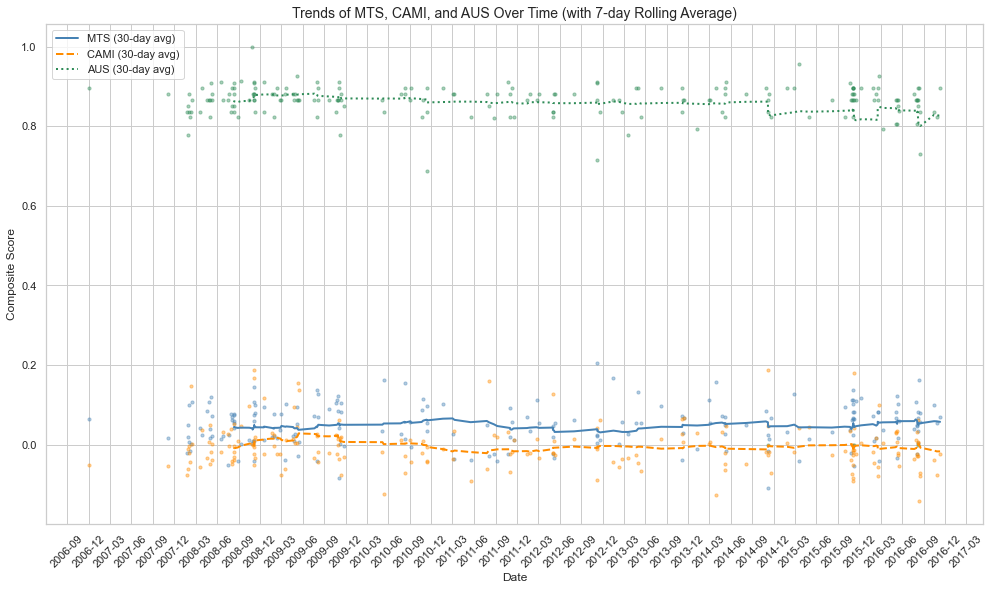

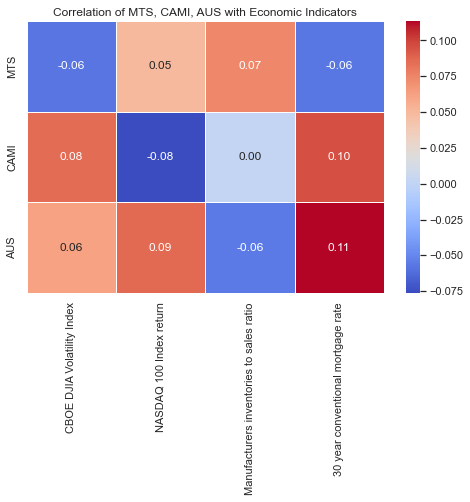

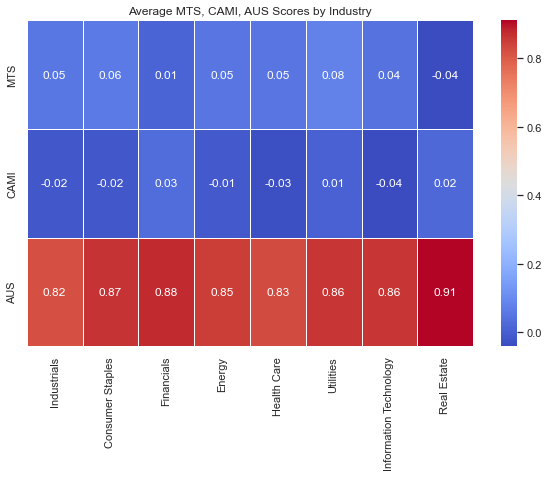

In [228]:
'''COMPOSITE METRICS'''
'''MODEL WEIGHTS'''

df = llm_outputs.copy()
composite_df = compute_scores(df, baseline_model, False, False)

# Select the supporting features, nlp_lables, and RR from final_df
final_df = composite_df[['RR']
                    + supporting_features_1
                    + supporting_features_2
                    + ['MTS', 'CAMI', 'AUS']
                    ]          

# reset index
final_df = final_df.reset_index(drop=True)
# drop duplicates
#final_df = final_df.drop_duplicates()

# In-Sample-Regression
y_train, y_test = final_df['RR'], final_df['RR']
X_train, X_test = final_df.drop(columns=['RR']), final_df.drop(columns=['RR'])

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the model
model = sm.OLS(y_train, X_train).fit()

# Print the summary of the model which includes p-values and significance levels
print(model.summary())

# Make predictions
y_pred = model.predict(X_test)

# Compute and print evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

# other metric
# Calculate the residuals
residuals = y_test - y_pred

# Plot the residuals
plt.figure(figsize=(10, 5))
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Recovery Rate')
plt.ylabel('Residuals')

# Display the plot
plt.show()

create_significant_chart(model)
create_colored_chart(model)
build_score_overview(composite_df)
build_heatmap_macro(composite_df)
build_heatmap_industries(composite_df)

                            OLS Regression Results                            
Dep. Variable:                     RR   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     78.12
Date:                Thu, 21 Nov 2024   Prob (F-statistic):          3.86e-259
Time:                        22:30:57   Log-Likelihood:                -4340.2
No. Observations:                1075   AIC:                             8750.
Df Residuals:                    1040   BIC:                             8925.
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

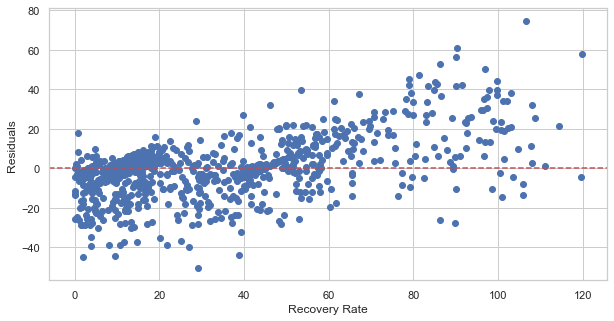

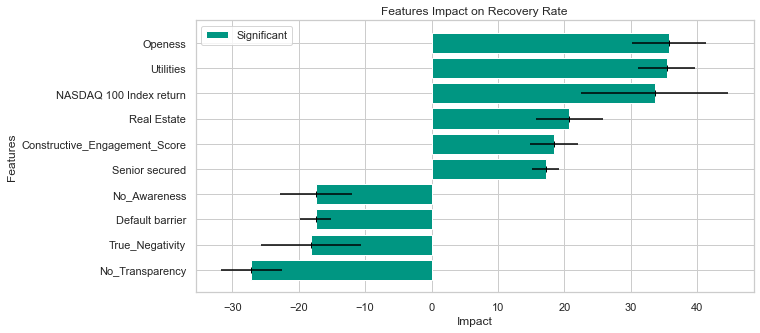

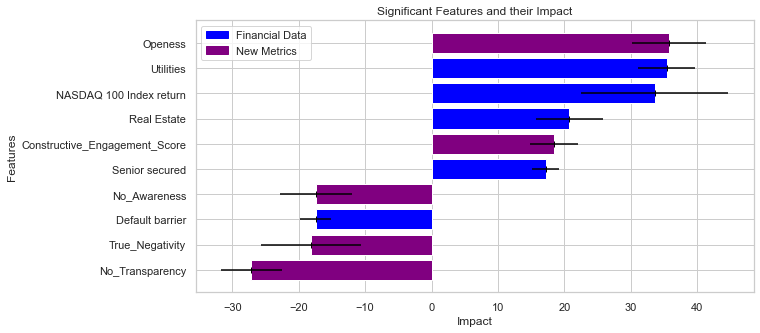

In [259]:
'''COMPOSITE METRICS'''
'''PCA'''

df = llm_outputs.copy()
composite_df = create_loadings(df)

# Select the supporting features, nlp_lables, and RR from final_df
final_df = composite_df[['RR']
                    + supporting_features_1
                    + supporting_features_2
                    + ['No_Transparency', 'No_Awareness', 'Openess']
                    + ['Emotional_Concerns', 'True_Satisfaction', 'True_Negativity']
                    + ['Constructive_Engagement_Score', 'Ambiguous_Emotion_Score']
                    ]
                    
# reset index
final_df = final_df.reset_index(drop=True)
# drop duplicates
#final_df = final_df.drop_duplicates()

# In-Sample-Regression
y_train, y_test = final_df['RR'], final_df['RR']
X_train, X_test = final_df.drop(columns=['RR']), final_df.drop(columns=['RR'])

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the model
model = sm.OLS(y_train, X_train).fit()

# Print the summary of the model which includes p-values and significance levels
print(model.summary())

# Make predictions
y_pred = model.predict(X_test)

# Compute and print evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

# other metric
# Calculate the residuals
residuals = y_test - y_pred

# Plot the residuals
plt.figure(figsize=(10, 5))
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Recovery Rate')
plt.ylabel('Residuals')

# Display the plot
plt.show()

create_significant_chart(model)
create_colored_chart(model)
#build_score_overview(composite_df)
#build_heatmap_macro(composite_df)
#build_heatmap_industries(composite_df)

In [198]:
final_df

,RR,CBOE DJIA Volatility Index,NASDAQ 100 Index return,Manufacturers inventories to sales ratio,30 year conventional mortgage rate,Communication Services,Consumer Discretionary,Senior secured,Time to maturity,Equity value,...,LTDIssuance2,Intangibility,Receivables1,MTS_Negative,MTS_Positive,CAMI_Negative,CAMI_Positive,Emotional_Concerns,Contradicting_Satisfaction,Emotion_Valuation
0,29.023972,23.14,0.085368,1.39,5.20,0,1,0,3014,635.12600,...,0.961366,0.238261,0.000000,-0.281960,-0.254373,-0.338734,-0.110190,-0.059131,0.132637,0.451903
1,8.869420,44.28,-0.025915,1.46,5.01,0,0,0,6361,0.00000,...,0.000000,0.000000,0.000000,-0.465649,-0.229273,-0.333165,-0.091217,-0.059131,-0.166476,-0.042417
2,33.210455,20.29,0.076193,1.20,5.88,0,0,0,6458,228.77559,...,0.000000,0.000000,0.000000,-0.507560,-0.254373,-0.480975,-0.091982,-0.059131,-0.148153,0.340474
3,11.875000,19.49,-0.096174,1.20,6.08,0,0,0,1502,-91.83100,...,0.002692,1.023794,0.000000,-0.543845,-0.352300,-0.506076,-0.248627,-0.059131,-0.103765,0.563783
4,18.340000,19.92,0.006565,1.20,6.26,0,0,0,1288,-96.67500,...,1.000000,0.076633,0.000000,-0.266926,-0.008106,-0.453536,-0.103025,-0.055189,-0.030487,0.028109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1070,51.999645,11.36,0.010977,1.39,4.16,0,0,0,1941,-662.32300,...,0.963511,0.170999,0.000091,-0.061399,0.016995,-0.195876,-0.103790,-0.055189,-0.203957,0.375630
1071,61.446887,11.36,0.010977,1.39,4.16,0,0,0,633,-662.32300,...,0.963511,0.170999,0.024634,-0.061399,0.016995,-0.195876,-0.103790,-0.055189,-0.203957,0.375630
1072,6.500000,14.91,-0.031751,1.42,3.59,0,0,0,1313,0.00000,...,0.000000,0.000000,0.040615,-0.322864,-0.256447,-0.338734,-0.146473,0.195203,-0.160636,0.159786
1073,8.922146,24.58,-0.018240,1.43,3.65,0,0,0,2362,35.21730,...,0.999481,0.000000,0.000000,-0.195533,-0.139642,-0.333481,-0.151881,0.291288,-0.152840,0.169177


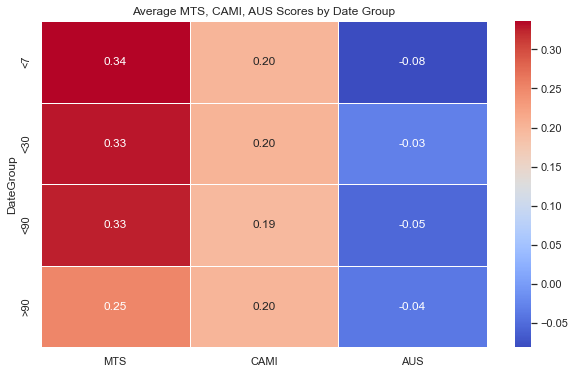

In [105]:
graph_df = composite_df[['Date', 'MTS', 'CAMI', 'AUS', 'call_ID', 'Ddate']]
graph_df = graph_df.drop_duplicates(subset=['Date', 'call_ID'])

# compute difference between dates
graph_df['Ddate'] = pd.to_datetime(graph_df['Ddate'])
graph_df['Date'] = pd.to_datetime(graph_df['Date'])
graph_df['DateDiff'] = (graph_df['Ddate'] - graph_df['Date']).dt.days

# divide into groups: <7, <30, <90, >90
graph_df['DateGroup'] = pd.cut(graph_df['DateDiff'], bins=[-1, 7, 30, 90, 1000], labels=['<7', '<30', '<90', '>90'])

# calculate average scores for each group
group_scores = graph_df.groupby('DateGroup')[['MTS', 'CAMI', 'AUS']].mean()

# Plotting the average scores for each group
plt.figure(figsize=(10, 6))
sns.heatmap(group_scores, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Average MTS, CAMI, AUS Scores by Date Group")
plt.show()

In [ ]:
''''Trade Level Analysis'''

# Load the trade-level data
trade_df = pd.read_csv('dealer/dealer_data_llm_output.csv', index_col=0)

In [57]:
primary_model = sm.load('models/primary_dealer_model.pkl')
non_primary_model = sm.load('models/non_primary_dealer_model.pkl')

['evasiveness', 'uncertainty', 'responsiveness', 'language_accessibility_presentation', 'pessimistic', 'vagueness', 'language_accessibility_qna', 'optimistic']
Setting vagueness to negative
Setting language_accessibility_qna to negative
Setting confidence to negative
Setting operational_trends to negative
Setting admiration to negative
Setting legal_issues to negative
Setting embarrassment to negative
Setting pride to negative
Setting recovery_strategies to negative
Setting remorse to negative
Setting liquidity_position to negative
Setting confusion to negative
Setting macroeconomic to negative
Setting joy_analysts to negative
Setting fear_analysts to negative
Setting sadness_analysts to negative
Setting disapproval_analysts to negative
                            OLS Regression Results                            
Dep. Variable:              dealer_RR   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.703
Method:         

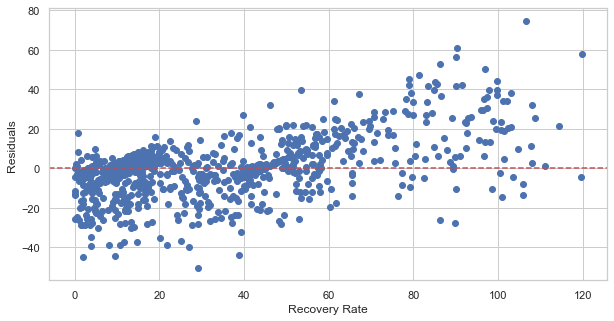

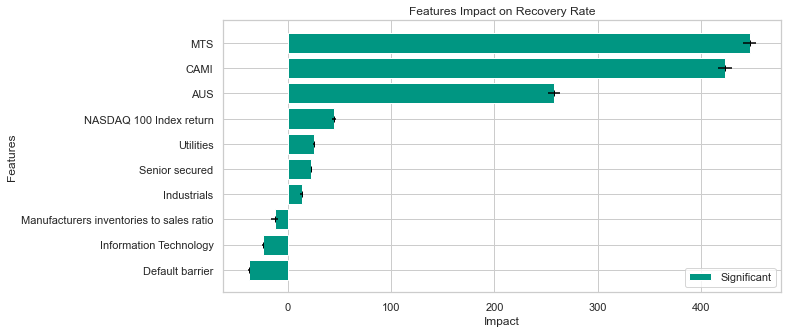

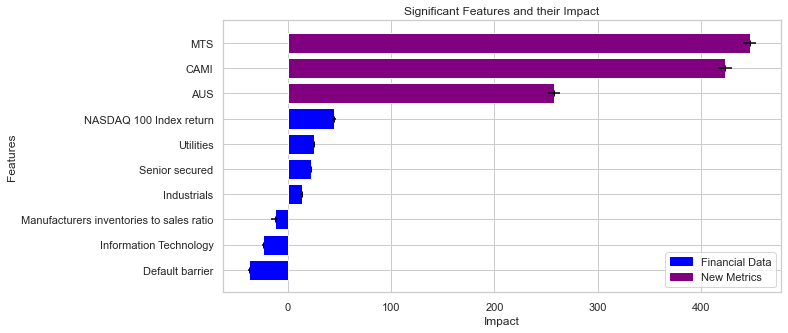

In [272]:
'''COMPOSITE METRICS'''
'''MODEL WEIGHTS'''
'''PRIMARY'''

df = trade_df.copy()

composite_df = compute_scores(df, primary_model, True, True)

# Select the supporting features, nlp_lables, and RR from final_df
final_df = composite_df[['dealer_RR', 'PrimaryDealer']
                    + supporting_features_1
                    + supporting_features_2
                    + ['MTS', 'CAMI', 'AUS']
                    ]
                    

# reset index
final_df = final_df.reset_index(drop=True)
# drop duplicates
final_df = final_df[final_df['PrimaryDealer'] == 1]

y = final_df['dealer_RR']
X = final_df.drop(columns=['dealer_RR', 'PrimaryDealer'])

X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

# Print the summary of the model which includes p-values and significance levels
print(model.summary())

# Make predictions
y_pred = model.predict(X)

# Compute and print evaluation metrics
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

# Plot the residuals
plt.figure(figsize=(10, 5))
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Recovery Rate')
plt.ylabel('Residuals')

# Display the plot
plt.show()

create_significant_chart(model)
create_colored_chart(model)

['evasiveness', 'uncertainty', 'responsiveness', 'pessimistic', 'positive_sentiment', 'vagueness', 'language_accessibility_qna', 'optimistic', 'language_accessibility_presentation']
Setting positive_sentiment to negative
Setting vagueness to negative
Setting asset_quality to negative
Setting confidence to negative
Setting disappointment to negative
Setting admiration to negative
Setting sadness to negative
Setting embarrassment to negative
Setting anger to negative
Setting desire to negative
Setting remorse to negative
Setting fear to negative
Setting confusion to negative
Setting industry_positioning to negative
Setting macroeconomic to negative
Setting optimism to negative
Setting joy_analysts to negative
Setting fear_analysts to negative
Setting sadness_analysts to negative
Setting analyst_concerns to negative
Setting disapproval_analysts to negative
                            OLS Regression Results                            
Dep. Variable:              dealer_RR   R-squared:     

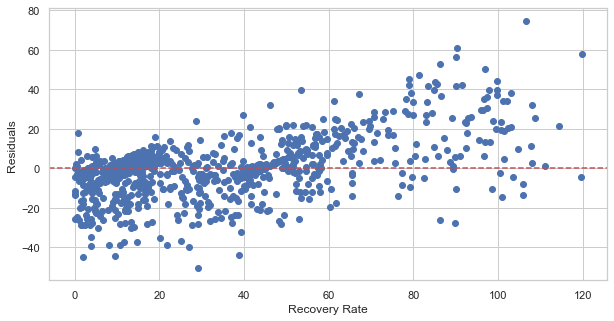

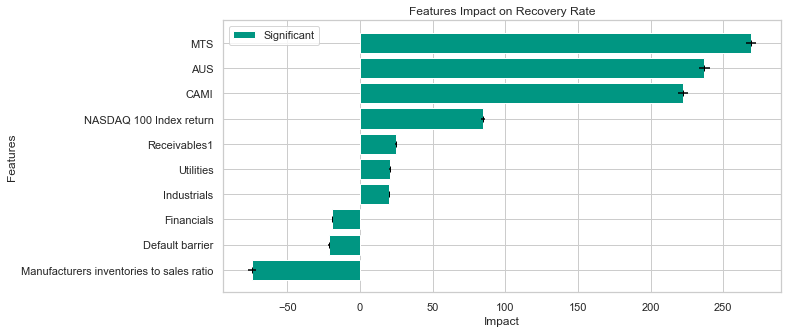

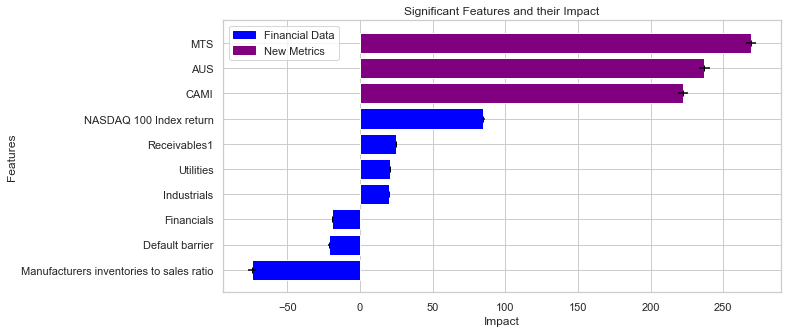

In [273]:
'''COMPOSITE METRICS'''
'''MODEL WEIGHTS'''
'''NON-PRIMARY'''

df = trade_df.copy()

composite_df = compute_scores(df, non_primary_model, True, True)

# Select the supporting features, nlp_lables, and RR from final_df
final_df = composite_df[['dealer_RR', 'PrimaryDealer']
                    + supporting_features_1
                    + supporting_features_2
                    + ['MTS', 'CAMI', 'AUS']
                    ]
                    

# reset index
final_df = final_df.reset_index(drop=True)
# drop duplicates
final_df = final_df[final_df['PrimaryDealer'] == 0]

y = final_df['dealer_RR']
X = final_df.drop(columns=['dealer_RR', 'PrimaryDealer'])

X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

# Print the summary of the model which includes p-values and significance levels
print(model.summary())

# Make predictions
y_pred = model.predict(X)

# Compute and print evaluation metrics
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

# Plot the residuals
plt.figure(figsize=(10, 5))
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Recovery Rate')
plt.ylabel('Residuals')

# Display the plot
plt.show()

create_significant_chart(model)
create_colored_chart(model)

                            OLS Regression Results                            
Dep. Variable:              dealer_RR   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     2132.
Date:                Thu, 21 Nov 2024   Prob (F-statistic):               0.00
Time:                        22:34:12   Log-Likelihood:            -1.0705e+05
No. Observations:               35535   AIC:                         2.142e+05
Df Residuals:                   35501   BIC:                         2.144e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

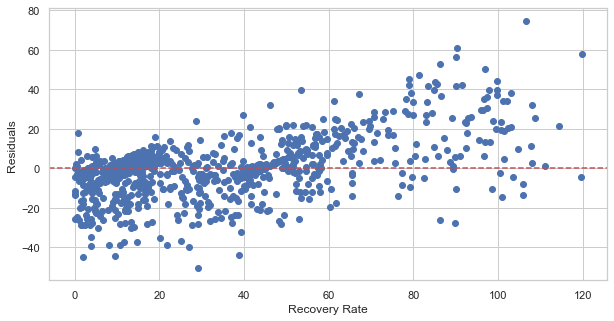

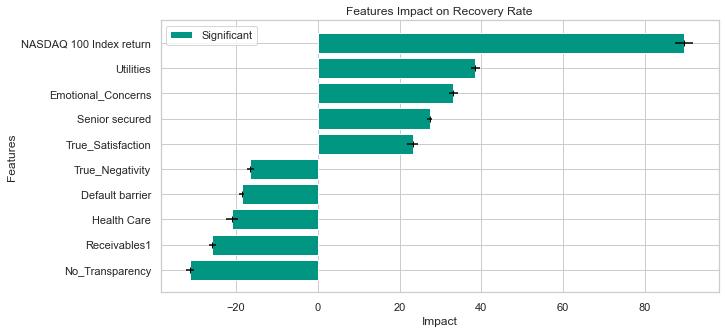

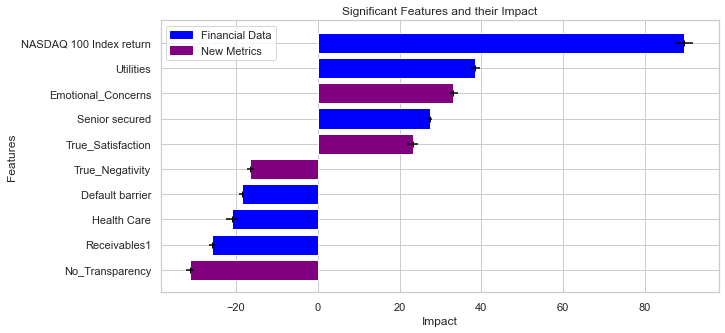

In [265]:
'''COMPOSITE METRICS'''
'''PCA'''
'''PRIMARY'''

df = trade_df.copy()
composite_df = create_loadings(df)

# Select the supporting features, nlp_lables, and RR from final_df
final_df = composite_df[['dealer_RR', 'PrimaryDealer']
                    + supporting_features_1
                    + supporting_features_2
                    + ['No_Transparency', 'No_Awareness', 'Openess']
                    + ['Emotional_Concerns', 'True_Satisfaction', 'True_Negativity']
                    + ['Emotion_Valuation']
                    ]
                    

# reset index
final_df = final_df.reset_index(drop=True)
# drop duplicates
final_df = final_df[final_df['PrimaryDealer'] == 1]

y = final_df['dealer_RR']
X = final_df.drop(columns=['dealer_RR', 'PrimaryDealer'])

X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

# Print the summary of the model which includes p-values and significance levels
print(model.summary())

# Make predictions
y_pred = model.predict(X)

# Compute and print evaluation metrics
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

# Plot the residuals
plt.figure(figsize=(10, 5))
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Recovery Rate')
plt.ylabel('Residuals')

# Display the plot
plt.show()

create_significant_chart(model)
create_colored_chart(model)

                            OLS Regression Results                            
Dep. Variable:              dealer_RR   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     2722.
Date:                Thu, 21 Nov 2024   Prob (F-statistic):               0.00
Time:                        22:34:19   Log-Likelihood:            -1.7875e+05
No. Observations:               45934   AIC:                         3.576e+05
Df Residuals:                   45900   BIC:                         3.579e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

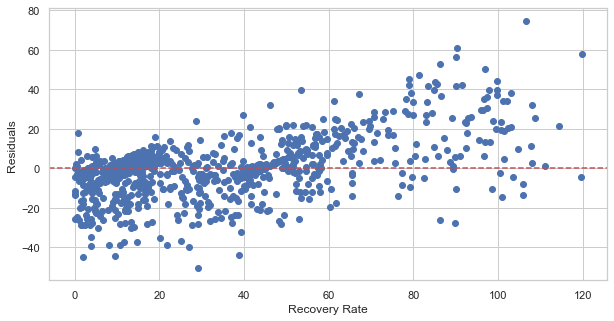

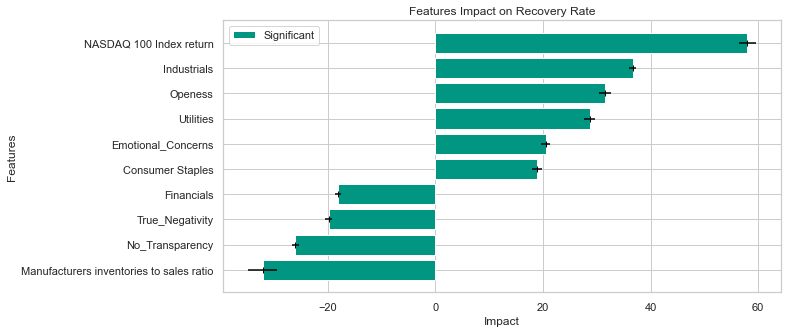

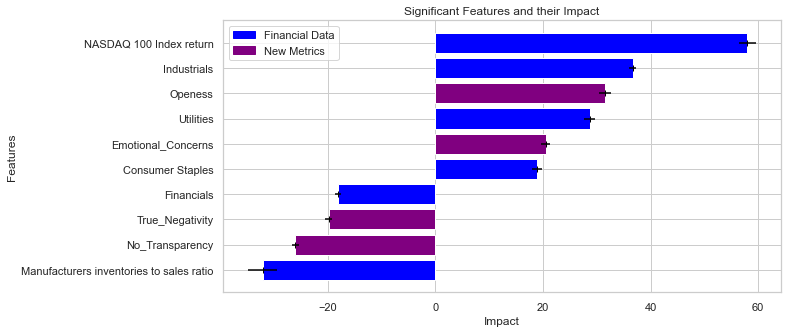

In [266]:
'''COMPOSITE METRICS'''
'''PCA'''
'''NON-PRIMARY'''

df = trade_df.copy()
composite_df = create_loadings(df)

# Select the supporting features, nlp_lables, and RR from final_df
final_df = composite_df[['dealer_RR', 'PrimaryDealer']
                    + supporting_features_1
                    + supporting_features_2
                    + ['No_Transparency', 'No_Awareness', 'Openess']
                    + ['Emotional_Concerns', 'True_Satisfaction', 'True_Negativity']
                    + ['Emotion_Valuation']
                    ]
                    

# reset index
final_df = final_df.reset_index(drop=True)
# drop duplicates
final_df = final_df[final_df['PrimaryDealer'] == 0]

y = final_df['dealer_RR']
X = final_df.drop(columns=['dealer_RR', 'PrimaryDealer'])

X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

# Print the summary of the model which includes p-values and significance levels
print(model.summary())

# Make predictions
y_pred = model.predict(X)

# Compute and print evaluation metrics
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

# Plot the residuals
plt.figure(figsize=(10, 5))
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Recovery Rate')
plt.ylabel('Residuals')

# Display the plot
plt.show()

create_significant_chart(model)
create_colored_chart(model)

                            OLS Regression Results                            
Dep. Variable:              dealer_RR   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     4425.
Date:                Thu, 21 Nov 2024   Prob (F-statistic):               0.00
Time:                        22:34:28   Log-Likelihood:            -3.0119e+05
No. Observations:               81469   AIC:                         6.024e+05
Df Residuals:                   81435   BIC:                         6.028e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

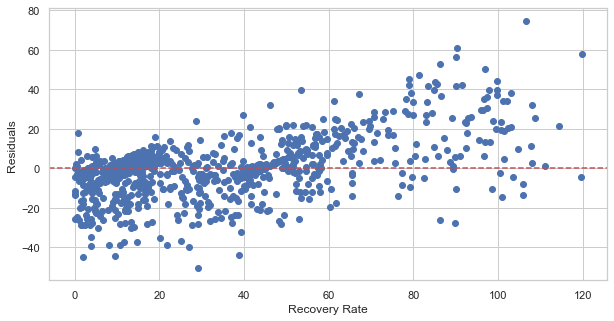

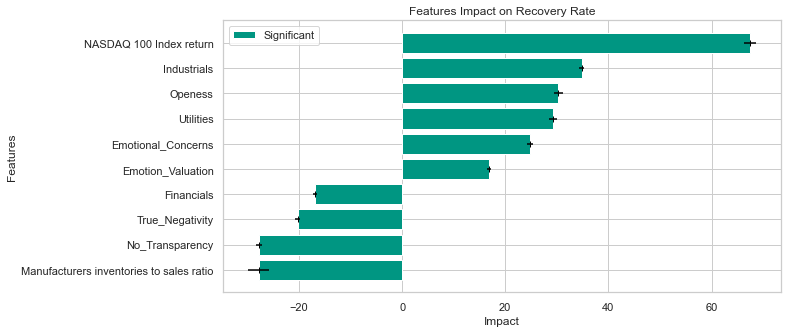

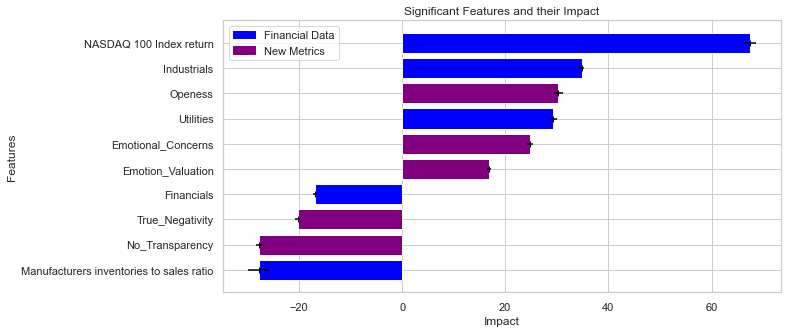

In [267]:
'''COMPOSITE METRICS'''
'''PCA'''
'''ALL DEALERS'''

df = trade_df.copy()
composite_df = create_loadings(df)

# Select the supporting features, nlp_lables, and RR from final_df
final_df = composite_df[['dealer_RR', 'PrimaryDealer']
                    + supporting_features_1
                    + supporting_features_2
                    + ['No_Transparency', 'No_Awareness', 'Openess']
                    + ['Emotional_Concerns', 'True_Satisfaction', 'True_Negativity']
                    + ['Emotion_Valuation']
                    ]
                    

# reset index
final_df = final_df.reset_index(drop=True)

y = final_df['dealer_RR']
X = final_df.drop(columns=['dealer_RR', 'PrimaryDealer'])

X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

# Print the summary of the model which includes p-values and significance levels
print(model.summary())

# Make predictions
y_pred = model.predict(X)

# Compute and print evaluation metrics
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

# Plot the residuals
plt.figure(figsize=(10, 5))
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Recovery Rate')
plt.ylabel('Residuals')

# Display the plot
plt.show()

create_significant_chart(model)
create_colored_chart(model)